### Noms : 
### - Berrissoul Saad
###  - El Fallah Mohamed
### DATA-INE 2

#### 1- Importation des librairies necessaires

In [10]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
np.set_printoptions(threshold=sys.maxsize)

df=pd.read_json("C:/Users/MyPC/Downloads/statoil-iceberg-classifier-challenge/data/processed/train.json")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1604 non-null   object
 1   band_1      1604 non-null   object
 2   band_2      1604 non-null   object
 3   inc_angle   1604 non-null   object
 4   is_iceberg  1604 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 62.8+ KB


# Concaténation des deux polarisations

In [11]:
df2=df.iloc[:,[1,4]]
df3=df.iloc[:,[2,4]]
df2.rename(columns={"band_1": "image"}, inplace=True)
df3.rename(columns={"band_2": "image"}, inplace=True)
df=pd.concat([df2,df3], ignore_index=True)
df=df.sample(frac=1).reset_index(drop=True)
df

C:\Users\MyPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,image,is_iceberg
0,"[-18.247763, -23.493374, -19.901279, -19.90127...",1
1,"[-17.077965, -19.218239, -18.026594, -18.72190...",0
2,"[-28.291798, -27.30752, -22.995605, -25.124796...",0
3,"[-26.035688, -28.435242, -26.984276, -23.02811...",1
4,"[-23.727724, -26.44105, -24.387875, -24.387947...",1
...,...,...
3203,"[-30.515923, -29.177046, -27.322023, -27.32202...",1
3204,"[-17.838644, -18.818421999999998, -19.633371, ...",0
3205,"[-27.013676, -25.770767, -23.949205, -22.44423...",1
3206,"[-22.513561, -23.61455, -26.035461, -29.873209...",1


# Normalisation des images

In [12]:
for i in range(len(df)):
    a=np.array(df["image"][i])
    arr=(a-np.min(a))/(np.max(a)-np.min(a))
    df["image"][i]=list(arr)

<ipython-input-12-96350fd900fd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["image"][i]=list(arr)


### Samples : Icebergs and ships

In [13]:
#sampling icerbergs and ships

sample_ice=df[df["is_iceberg"]==1].sample(n=100)
sample_ship=df[df["is_iceberg"]==0].sample(n=100)
sample_ice.index=[i for i in range(100)]
sample_ship.index=[i for i in range(100)]


## Images des Icebergs

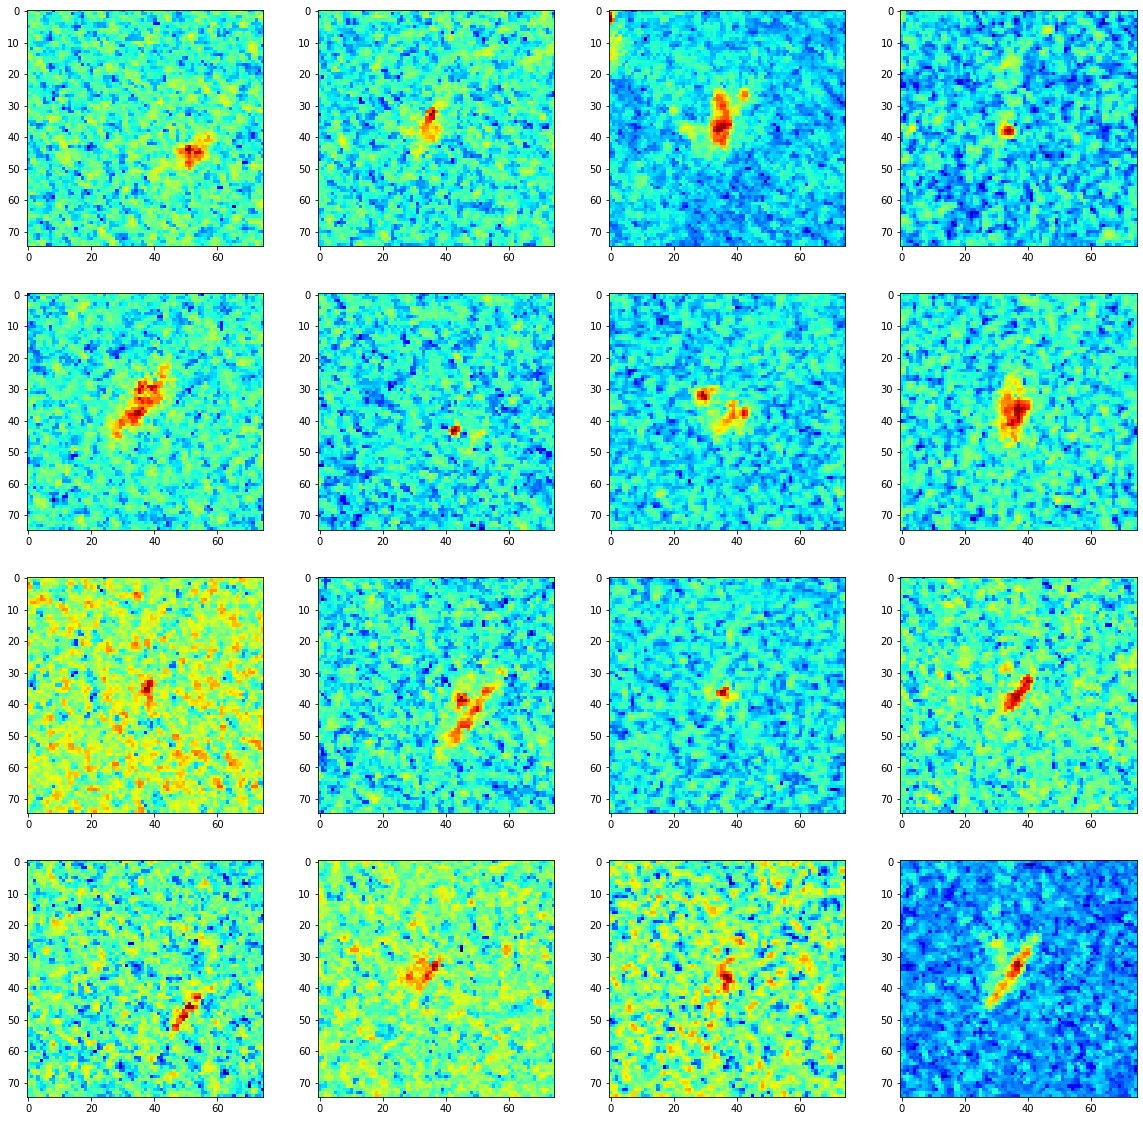

In [14]:
fig=plt.figure(figsize=(20,20))
for i in range(16):
    ax=fig.add_subplot(4,4,i+1)
    arr=np.array(sample_ice["image"][i])
    ax.imshow(arr.reshape(75,75),interpolation='none',cmap='jet')


## Images des Bateaux

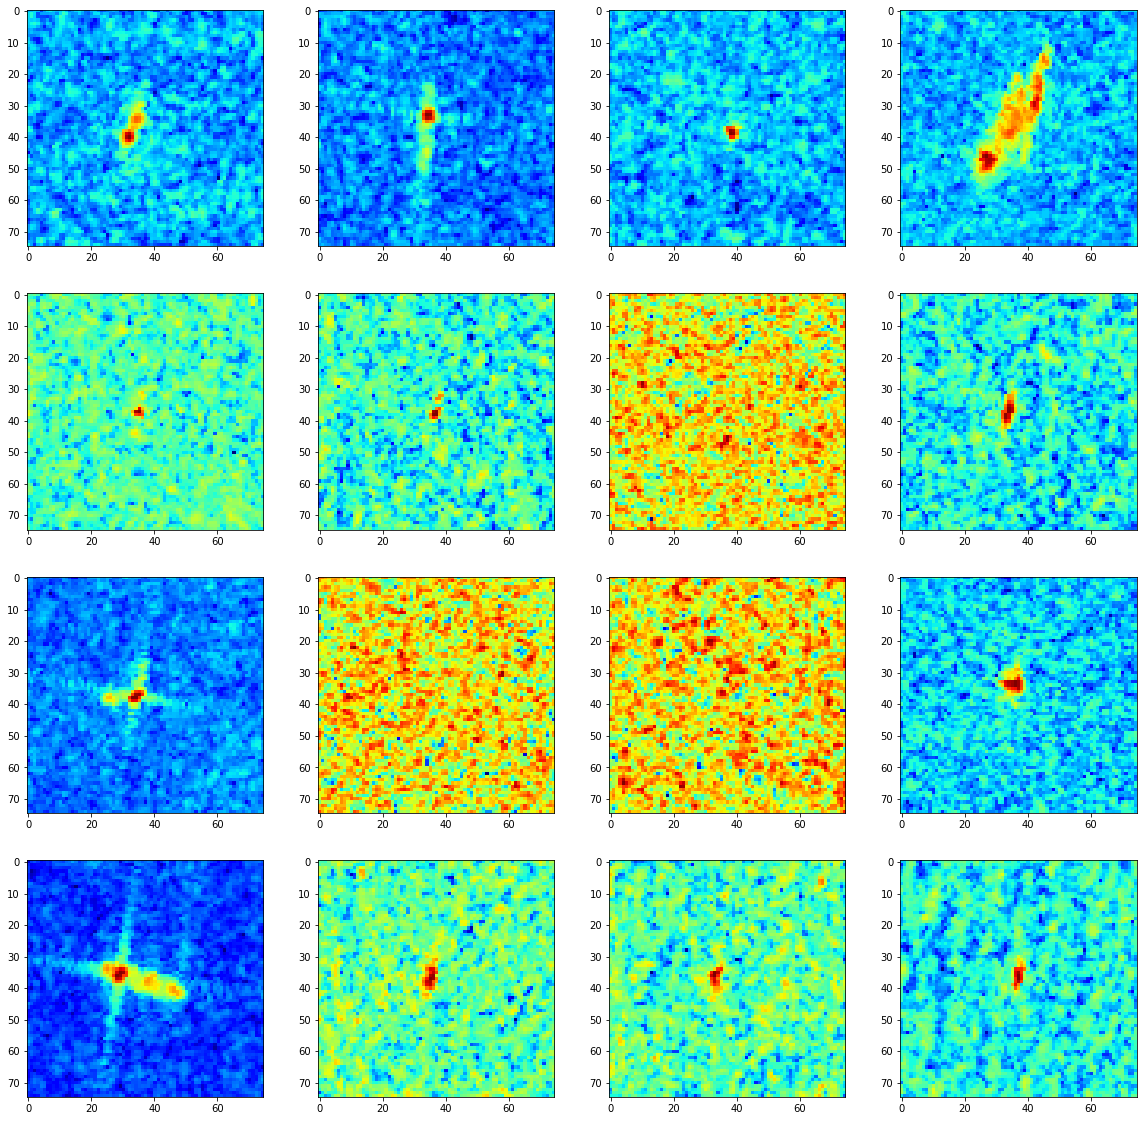

In [15]:
fig=plt.figure(figsize=(20,20))
for i in range(16):
    ax=fig.add_subplot(4,4,i+1)
    arr=np.array(sample_ship["image"][i])
    ax.imshow(arr.reshape(75,75),interpolation='none',cmap='jet')

## Construction de CNN

In [16]:
import torch 
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim


In [17]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
        self.conv2=nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
        self.conv3=nn.Conv2d(in_channels=12,out_channels=24,kernel_size=7)

        self.fc1=nn.Linear(in_features=24*4*4, out_features=240)
        self.fc2=nn.Linear(in_features=240, out_features=120)
        self.fc3=nn.Linear(in_features=120, out_features=60)
        self.out=nn.Linear(in_features=60, out_features=2)
        
    def forward(self, t):
        t=self.conv1(t)
        t=f.max_pool2d(f.relu(t),kernel_size=3, stride=2)
        t=self.conv2(t)
        t=f.max_pool2d(f.relu(t),kernel_size=3, stride=2)
        t=self.conv3(t)
        t=f.max_pool2d(f.relu(t),kernel_size=3, stride=2)

        t=t.reshape(-1,24*4*4)
        t=self.fc1(t)
        t=f.relu(t)

        t=self.fc2(t)
        t=f.relu(t)
        
        t=self.fc3(t)
        t=f.relu(t)

        t=self.out(t)
        return t
        


In [18]:
class dataset(Dataset):
    def __init__(self,data, transform=None,):
        self.data=data
        self.transform=transform

    def __getitem__(self, index):
        image=np.array(self.data.loc[index,["image"]][0]).reshape(75,75)
        label=self.data["is_iceberg"][index]
      
        if self.transform :
            image=self.transform(image)

        return image,label
    

    def __len__(self):
        return len(self.data)

is_iceberg    0.468905
dtype: float64

,is_iceberg
count,1608.000000
mean,0.468905
std,0.499187
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


# DATA Loading

In [19]:
train_set1=dataset(df.loc[0:2200,:],transform=transforms.ToTensor())
new_transforms=transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomRotation(degrees=60),
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=1),    
])
train_set2=dataset(df.loc[0:1000,:],transform=new_transforms)
train_data=torch.utils.data.ConcatDataset([train_set1,train_set2])
train_data_loader=DataLoader(train_data, batch_size=50, shuffle=True)
network=Network()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.0)


In [20]:
len(train_data)

3202

### Learning loop

In [50]:
for epoch in range(2):
    total_loss=0
    for batch in train_data_loader:
        images, labels=batch
        preds=network(images.float())
        loss=f.cross_entropy(preds,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print('loss in epoch ',epoch, " = ",total_loss)
    

loss in epoch  0  =  14.068630963563919
loss in epoch  1  =  12.784723617136478


In [52]:

train_test= DataLoader(train_data, batch_size=3202)
images, labels=next(iter(train_test))
preds=network(images.float())
print(labels)
print(preds.argmax(dim=1))

tensor([1, 0, 0,  ..., 1, 1, 1])
tensor([1, 0, 0,  ..., 1, 1, 1])


### Training accuracy

In [53]:
s=0
for i in range(3202):
    if labels[i]==preds.argmax(dim=1)[i]:
        s+=1
        
print("training accuracy : ", s/3202)

training accuracy :  0.9078700811992505


### Model test

In [54]:
test_set=dataset(df.loc[2201:,:].reset_index(drop=True),transform=transforms.ToTensor())
test_loader=DataLoader(test_set, batch_size=1007)
img, lab=next(iter(test_loader))
prediction=network(img.float())
print(prediction.argmax(dim=1))

tensor([1, 1, 0,  ..., 0, 0, 0])


In [113]:
crt=0
for i in range(1007):
   if prediction.argmax(dim=1)[i]==lab[i]:
        crt+=1
print(crt, " test accuracy : ", crt/1007)

827  test accuracy :  0.8212512413108243


In [117]:

i=3200

img_test=torch.tensor(df["image"][i]).reshape(75,75)
img_test =torch.unsqueeze(img_test,0)
img_test =torch.unsqueeze(img_test,0)
estim=network(img_test.float())
print(estim)
print(df["is_iceberg"][i])
print(estim.argmax(dim=1))

tensor([[-2.4259,  2.8086]], grad_fn=<AddmmBackward>)
1
tensor([1])


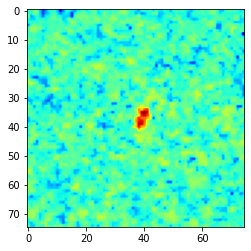

In [106]:
plt.imshow(np.array(df["image"][i]).reshape(75,75),interpolation=None, cmap="jet")

### Le modele a confirmé qu il s'agit d'un iceberg